In [129]:
import pandas as pd
##Pre-processing
from sklearn import preprocessing
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.utils import class_weight

#Model Evaluation
from sklearn import metrics
from sklearn.metrics import confusion_matrix,ConfusionMatrixDisplay, roc_auc_score,precision_score,recall_score,f1_score
from sklearn.metrics import classification_report
from sklearn.model_selection import GridSearchCV,RandomizedSearchCV
from scipy.sparse import csr_matrix, hstack
from scipy.stats import ks_2samp


#Model Building
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import StratifiedKFold
from sklearn.ensemble import RandomForestClassifier
from mlxtend.classifier import StackingCVClassifier
from sklearn import model_selection
import xgboost as xgb

#All Purpose
import numpy as np
import pickle
import seaborn as sns
import warnings
import joblib
import matplotlib.pyplot as plt

%matplotlib inline
warnings.filterwarnings("ignore")

In [130]:
path = 'E:\\Shobhit\\MSDS\\Capstone\\Y1_Capstone\\data\\final_data'
df_s1_data = pd.read_csv(f'{path}\\train_test_scenario_1.csv') #Reading Scenario 1 data

In [131]:
print(df_s1_data.shape)
df_s1_data.head()

(23182, 28)


,device_id,phone_brand,device_model,Median_Latitude,Median_Longitude,Number_of_Events,Latitude_Diff_Morning_Evening,Longitude_Diff_Morning_Evening,Latitude_Diff_Morning_Night,Longitude_Diff_Morning_Night,...,Travel_Apps_Used,Sports_Apps_Used,Comics_and_animation_Apps_Used,Education_Apps_Used,Media_Apps_Used,Home_and_furniture_Apps_Used,Health_and_fitness_Apps_Used,gender,age,train_test_flag
0,-7548291590301750000,Huawei,è£è€€3C,33.98,116.79,1,0.0,0.0,0.0,0.0,...,0,0,0,0,1,0,0,M,33,train
1,7442042493953950000,Huawei,hu1 plus,39.43,116.98,1,0.0,0.0,0.0,0.0,...,0,0,0,0,1,0,1,M,26,train
2,-800490591774117000,Huawei,hu1 Plus,0.00,0.00,1,0.0,0.0,0.0,0.0,...,0,0,0,0,1,0,1,F,33,train
3,-7430262216439700000,Huawei,Mate 7,22.66,114.33,6,0.0,0.0,0.0,0.0,...,0,0,1,0,1,1,1,M,42,train
4,5263633571423510000,Huawei,hu1 Plus,30.39,114.42,17,0.0,0.0,0.0,0.0,...,0,0,0,0,1,0,1,M,27,train


In [132]:
df_s1_data.dtypes

device_id                             int64
phone_brand                          object
device_model                         object
Median_Latitude                     float64
Median_Longitude                    float64
Number_of_Events                      int64
Latitude_Diff_Morning_Evening       float64
Longitude_Diff_Morning_Evening      float64
Latitude_Diff_Morning_Night         float64
Longitude_Diff_Morning_Night        float64
Cluster_Label                       float64
Other_Apps_Used                       int64
Finance_Apps_Used                     int64
Science_and_Technology_Apps_Used      int64
Shopping_Apps_Used                    int64
Property_Industry_Apps_Used           int64
Gaming_Apps_Used                      int64
Maternal_and_child_Apps_Used          int64
Travel_Apps_Used                      int64
Sports_Apps_Used                      int64
Comics_and_animation_Apps_Used        int64
Education_Apps_Used                   int64
Media_Apps_Used                 

##### Encoding Categorical Variables

- For encoding categorical variables we would be encoding them using one-hot encoder.
- Categorical variables like Science_and_Technology_Apps_Used and Other_Apps_Used are already encoded so they would not be
required for one hot encoding.

In [133]:
def perform_data_encoding(data, ohe_encoder = None,firstRun=True):
    df_data_enc = data.copy()
    #One hot encoding categorical variables
    df_data_temp = data.drop(columns= ['gender','age','device_id','train_test_flag'],axis=1)
    categorical_cols = df_data_temp.select_dtypes(include = ['object','category']).columns.tolist()
    for columnName in df_data_temp.columns:
        if 'Apps_Used' in columnName or 'Label' in columnName:
            categorical_cols.append(columnName)
    
    enc = preprocessing.OneHotEncoder(sparse=False) if firstRun else ohe_encoder
    cols = [columnName for columnName in categorical_cols if 'Apps_Used' not in columnName] 
    
    if firstRun:
        enc.fit(df_data_enc[cols])
    enc_data = enc.transform(df_data_enc[cols]) 
    df_enc = pd.DataFrame(enc_data,columns = enc.get_feature_names_out(cols))
    enocoded_column_names = df_enc.columns
    print(df_enc.shape)
    
    #For columns one hot encoded have to be removed from the dataframe
    print(f'Before Dropping:{df_data_enc.shape}')
    print(cols)
    df_data_enc.drop(columns = cols,axis=1,inplace=True)
    print(f'After Dropping:{df_data_enc.shape}')
    
    #Merging the encoded data with the original dataframe
    print(f'Before encoding:{df_enc.shape}')
    df_data_enc = pd.concat([df_data_enc,df_enc],axis=1)
    print(f'After encoding:{df_data_enc.shape}')
    
    return df_data_enc, enocoded_column_names, categorical_cols, enc

In [134]:
df_s1_data_enc, enocoded_column_names, categorical_cols, ohe = perform_data_encoding(df_s1_data)

##### In order to have the same fitted encoder to execute every time the notebook is run would be storing that once fitting it.

In [7]:
# Saving OneHotEncoder
path = 'E:\\Shobhit\\MSDS\\Capstone\\Y1_Capstone\\MLModels'
joblib.dump(ohe, f'{path}\\ohe.joblib')

['E:\\Shobhit\\MSDS\\Capstone\\Y1_Capstone\\MLModels\\ohe.joblib']

In [8]:
# Load the saved OneHotEncoder
# path = 'E:\\Shobhit\\MSDS\\Capstone\\Y1_Capstone\\MLModels'
# ohe_saved = joblib.load(f'{path}\\ohe.joblib')

In [9]:
#Peforming One Hot Encoding from Saved Encoder
# df_s1_data_enc,enocoded_column_names, categorical_cols, ohe = perform_data_encoding(df_s1_data, ohe_saved, False)

In [10]:
#Getting the numerical columns from the data
numerical_cols = set(df_s1_data.drop(columns= ['gender','age','device_id','train_test_flag'],axis=1).columns) - set(categorical_cols)
numerical_cols = list(sorted(numerical_cols))
numerical_cols

['Latitude_Diff_Morning_Evening',
 'Latitude_Diff_Morning_Night',
 'Longitude_Diff_Morning_Evening',
 'Longitude_Diff_Morning_Night',
 'Median_Latitude',
 'Median_Longitude',
 'Number_of_Events']

#### Scaling Numerical Columns Using Standar Scaler

In [11]:
def perform_standard_scaler(data, numerical_cols, scaler_m = None,firstRun=True):
    scaler = StandardScaler() if firstRun else scaler_m
    if firstRun:
        scaler.fit(df_s1_data_enc[numerical_cols])
    
    scaled_array = scaler.transform(data[numerical_cols])
    scaled_df = pd.DataFrame(scaled_array, columns=numerical_cols, index=data.index)
    
    return scaled_df, scaler

##### In order to have the same fitted standar scaler to execute every time the notebook is run would be storing that once fitting it.

In [12]:
scaled_df,scaler = perform_standard_scaler(df_s1_data_enc, numerical_cols, firstRun=True)
print(scaled_df.shape)

(23182, 7)


In [13]:
# Saving StandarScaler
path = 'E:\\Shobhit\\MSDS\\Capstone\\Y1_Capstone\\MLModels'
joblib.dump(scaler, f'{path}\\standar_scaler.joblib')

['E:\\Shobhit\\MSDS\\Capstone\\Y1_Capstone\\MLModels\\standar_scaler.joblib']

In [14]:
# Load the saved Standard Scaler
# path = 'E:\\Shobhit\\MSDS\\Capstone\\Y1_Capstone\\MLModels'
# standard_scaler_saved = joblib.load(f'{path}\\standar_scaler.joblib')

In [15]:
#Peforming Standard Scaling  from saved Standard Scaler
scaled_df,scaler = perform_standard_scaler(df_s1_data_enc, numerical_cols,standard_scaler_saved, firstRun=False)
print(scaled_df.shape)

In [16]:
#Merging the encoded data with the original dataframe
print(f'Before:{df_s1_data_enc.shape}')
df_s1_data_enc = pd.concat([df_s1_data_enc.drop(numerical_cols, axis=1), scaled_df], axis=1)
print(f'After:{df_s1_data_enc.shape}')

Before:(23182, 1034)
After:(23182, 1034)


### Splitting Data Into Train_Test Split 

In [17]:
#Training Data
df_s1_data_train = df_s1_data_enc[df_s1_data_enc['train_test_flag'] == 'train']

In [18]:
# Saving Training Data
path = 'E:\\Shobhit\\MSDS\\Capstone\\Y1_Capstone\\MLModels'
df_s1_data_train.to_csv(f'{path}\\df_s1_data_train.csv', index=False)

In [135]:
#Reading Saved Training Data
# path = 'E:\\Shobhit\\MSDS\\Capstone\\Y1_Capstone\\MLModels'
# df_s1_data_train = pd.read_csv(f'{path}\\df_s1_data_train.csv')

In [136]:
df_s1_data_train.shape

(17391, 1034)

In [137]:
df_s1_data_train.drop('train_test_flag',axis=1,inplace=True)
df_s1_data_train.shape

(17391, 1033)

In [138]:
#Separating target variables with features for training data
#For Male we would be denoting by 1 and for female by 0
X_train_s1 = df_s1_data_train.drop(columns= ['gender','age','device_id'],axis=1)
Y_train_s1_age = df_s1_data_train['age']
Y_train_s1_gender = df_s1_data_train['gender'].apply(lambda gender : 1 if gender == 'M' else 0)
Y_train_s1_gender
print(X_train_s1.shape)
print(Y_train_s1_age.shape)
print(Y_train_s1_gender.shape)

(17391, 1030)
(17391,)
(17391,)


In [23]:
#Test Data
df_s1_data_test = df_s1_data_enc[df_s1_data_enc['train_test_flag'] == 'test']
df_s1_data_test.shape

(5791, 1034)

In [24]:
# Saving Test Data
path = 'E:\\Shobhit\\MSDS\\Capstone\\Y1_Capstone\\MLModels'
df_s1_data_test.to_csv(f'{path}\\df_s1_data_test.csv', index=False)

In [1]:
#Reading Saved Test Data
# path = 'E:\\Shobhit\\MSDS\\Capstone\\Y1_Capstone\\MLModels'
# df_s1_data_test = pd.read_csv(f'{path}\\df_s1_data_test.csv')
# df_s1_data_test.shape

In [140]:
df_s1_data_test.drop('train_test_flag',axis=1,inplace=True)
df_s1_data_test.shape

(5791, 1033)

In [141]:
#Separating target variables with features for test data
X_test_s1 = df_s1_data_test.drop(columns= ['gender','age','device_id'],axis=1)
Y_test_s1_age = df_s1_data_test['age']
Y_test_s1_gender = df_s1_data_test['gender'].apply(lambda gender : 1 if gender == 'M' else 0)
print(X_test_s1.shape)
print(Y_test_s1_age.shape)
print(Y_test_s1_gender.shape)

(5791, 1030)
(5791,)
(5791,)


In [142]:
Y_train_s1_gender.mean()

0.6540739462940601

In [143]:
Y_test_s1_gender.mean()

0.6568813676394405

### Creating Helper Functions for Model Evaluation

In [204]:
#Below dict will contain all the evaluation metrics for each model which would be later used for comparison
model_evaluation_dict_gender = {
    'Model_Name':[],
    'Training_Accuracy':[],
    'Testing_Accuracy':[],
    'Precision_Training':[],
    'Precision_Testing':[],
    'Recall_Training':[],
    'Recall_Testing':[],
    'F1Score_Training':[],
    'F1Score_Testing':[],
    'AUC_Training':[],
    'AUC_Testing':[],
    'KS_Training_Male':[],
    'KS_Testing_Male':[],
    'KS_Training_Female':[],
    'KS_Testing_Female':[],
    'Top3_Probability_Bands_KSTable':[],
    'Bottom3_Probability_Bands_KSTable':[],
}

In [205]:
def plot_and_get_roc_auc_curve(model, data, y_true):
    y_pred = model.predict_proba(data)[:,1]
    fpr, tpr, _ = metrics.roc_curve(y_true,  y_pred)
    auc = metrics.roc_auc_score(y_true, y_pred)
    plt.plot(fpr,tpr,label="AUC="+str(auc))
    plt.title('ROC_AUC_Curve')
    plt.plot([0, 1], [0, 1], color="green", linestyle="--")
    plt.ylabel('True Positive Rate')
    plt.xlabel('False Positive Rate')
    plt.legend(loc=4)
    plt.show()

    return auc

In [206]:
def get_top3_bottom3_decile_KS(model, data, y_true):
    probs = model.predict_proba(data)[:,1]
    
    #dataframe with true labels and predicted probabilities
    df = pd.DataFrame({'y_true': y_true, 'y_scores': probs})

    # deciles based on predicted probabilities
    df['decile'] = pd.qcut(df['y_scores'], 10, duplicates='drop', labels=False)

    # group by decile and calculate cumulative percentage of events and non-events
    grouped = df.groupby('decile')
    
    df['min_prob'] = grouped['y_scores'].min()
    df['max_prob'] = grouped['y_scores'].max()
    
    df['cum_event_pct'] = grouped['y_true'].cumsum() / df['y_true'].sum()
    df['cum_nonevent_pct'] = (1 - grouped['y_true'].sum()).cumsum() / (1 - df['y_true']).sum()

    # KS statistic for each decile
    df['KS'] = np.abs(df['cum_event_pct'] - df['cum_nonevent_pct'])

    # identify probability bands for top 3 and bottom 3 deciles
    top_3 = df.nlargest(3, 'KS')
    bottom_3 = df.nsmallest(3, 'KS')

    # print results
    print('Top 3 deciles:')
    print(top_3)
    print('Bottom 3 deciles:')
    print(bottom_3)
    
    return top_3[['min_prob', 'max_prob']], bottom_3[['min_prob', 'max_prob']]

In [207]:
def calculate_KS(model, data, y_true):
    # get the predicted probabilities for the data
    probs = model.predict_proba(data)
    
    # calculate the KS statistic for each class
    ks_0 = ks_2samp(probs[:, 0], y_true) #For Female
    ks_1 = ks_2samp(probs[:, 1], y_true) #For Male
    
    print('KS statistic for class Female:', ks_0)
    print('KS statistic for class Male:', ks_1)
    
    return ks_0, ks_1

In [208]:
def evaluate_model(model, data, y_true, isTraining=True):
    label = 'Training' if isTraining else 'Testing'
    
    print(f'Evaluating {label} performance')
    
    #Prediciting target variable on training data
    y_pred = model.predict(data)
    #Calculating Accuracy
    accuracy = metrics.balanced_accuracy_score(y_true, y_pred)
    print(f'Accuracy:{accuracy}')
    
    #Calculating Precision and Recall Score
    precision = precision_score(y_true, y_pred, average="weighted")
    recall = recall_score(y_true, y_pred, average="weighted")
    print(f'Precision:{precision}')
    print(f'Recall:{recall}')
    
    #Calculating F1-Score
    f1 = f1_score(y_true, y_pred)
    print(f'F1Score:{f1}')
    
    #Plotting Confusion Matrix
    cm = confusion_matrix(y_true, y_pred, labels=[0,1])
    disp = ConfusionMatrixDisplay(confusion_matrix=cm,display_labels=[0,1])
    disp.plot()
    
#     plt.show()
    
    #Evaluating model using KS Statistic
    ks_0, ks_1 = calculate_KS(model, data, y_true)    
    
    #Adding above generated evaluation metrics to the model_evaluation_dict_gender
    model_evaluation_dict_gender[f'{label}_Accuracy'].append(accuracy)
    model_evaluation_dict_gender[f'Precision_{label}'].append(precision)
    model_evaluation_dict_gender[f'Recall_{label}'].append(recall)
    model_evaluation_dict_gender[f'F1Score_{label}'].append(f1)
    model_evaluation_dict_gender[f'KS_{label}_Male'].append(ks_1)
    model_evaluation_dict_gender[f'KS_{label}_Female'].append(ks_0)
    if isTraining:
        #Getting top3 and bottom3 probability bonds as per KS table
        top3, bottom3 = get_top3_bottom3_decile_KS(model, data, y_true)
        model_evaluation_dict_gender['Top3_Probability_Bands_KSTable'].append(str(top3.values.tolist()))
        model_evaluation_dict_gender['Bottom3_Probability_Bands_KSTable'].append(str(bottom3.values.tolist()))


### Logistic Regression Model for Predicting `Gender` for Scenario 1

- Logistic regression model will be used as a benchmark to compare the other Machine learning models.

In [209]:
Y_train_s1_gender.value_counts()

1    11375
0     6016
Name: gender, dtype: int64

- We have an unbalanced data set as there are more Male labels as compared to Females

In [210]:
#As it is an unbalanced data set compute the appropiate class weight to be assigned to the model
weights = class_weight.compute_class_weight(class_weight='balanced',classes=np.unique(Y_train_s1_gender),y = Y_train_s1_gender)
print(weights)
class_weights = dict(zip(np.unique(Y_train_s1_gender), weights))
print(class_weights)

[1.44539561 0.76443956]
{0: 1.4453956117021276, 1: 0.7644395604395604}


In [211]:
#Declaring the Logistic Regression Model and training the model on the train data
'''
Model was trained and in order to avoid running it multiple times it was saved in pickle file
Uncomment below if running for first time and do not have the saved model.
'''
# lr_model = LogisticRegression(class_weight = class_weights, random_state=100, max_iter=1500)
# lr_model.fit(X_train_s1, Y_train_s1_gender)

'\nModel was trained and in order to avoid running it multiple times it was saved in pickle file\nUncomment below if running for first time and do not have the saved model.\n'

In [212]:
# Saving the Logistic Regression Model as a pickle in a file
# Uncomment Below if Running for First Time
# path = 'E:\\Shobhit\\MSDS\\Capstone\\Y1_Capstone\\MLModels'
# filename = f'{path}\\Logistic_Regression_Gender_Scenario1.pkl'
# pickle.dump(lr_model, open(filename, 'wb'))

In [213]:
# Reading saved Logistic regression model
path = 'E:\\Shobhit\\MSDS\\Capstone\\Y1_Capstone\\MLModels'
filename = f'{path}\\Logistic_Regression_Gender_Scenario1.pkl'
lr_model = pickle.load(open(filename, 'rb'))
print(lr_model)

LogisticRegression(class_weight={0: 1.4453956117021276, 1: 0.7644395604395604},
                   max_iter=1500, random_state=100)


In [214]:
lr_model.classes_

array([0, 1], dtype=int64)

#### Evaluating the Logistic Regression classifier on Training Data Set

Evaluating Training performance
Accuracy:0.6414541369534721
Precision:0.6726390973328272
Recall:0.6454487953539187
F1Score:0.7071340362876413
KS statistic for class Female: KstestResult(statistic=0.6540739462940601, pvalue=0.0)
KS statistic for class Male: KstestResult(statistic=0.6540739462940601, pvalue=0.0)
Top 3 deciles:
   y_true  y_scores  decile  min_prob  max_prob  cum_event_pct  \
9       0  0.708912       8  0.709863  0.986476       0.000176   
8       0  0.275556       0  0.647232  0.709862       0.000000   
7       1  0.518214       4  0.601566  0.647196       0.000088   

   cum_nonevent_pct        KS  
9         -1.889129  1.889305  
8         -1.635306  1.635306  
7         -1.398604  1.398692  
Bottom 3 deciles:
   y_true  y_scores  decile  min_prob  max_prob  cum_event_pct  \
0       1  0.620767       7  0.058220  0.312865       0.000088   
1       1  0.366599       1  0.312891  0.387476       0.000088   
2       0  0.419300       2  0.387518  0.440079       0.000000  

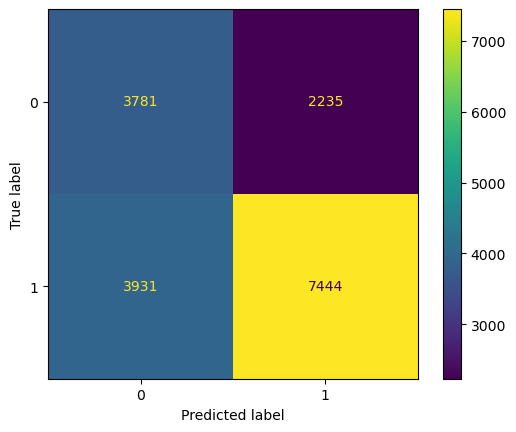

In [215]:
model_evaluation_dict_gender['Model_Name'].append('Logistic_Regression')
evaluate_model(lr_model, X_train_s1, Y_train_s1_gender)

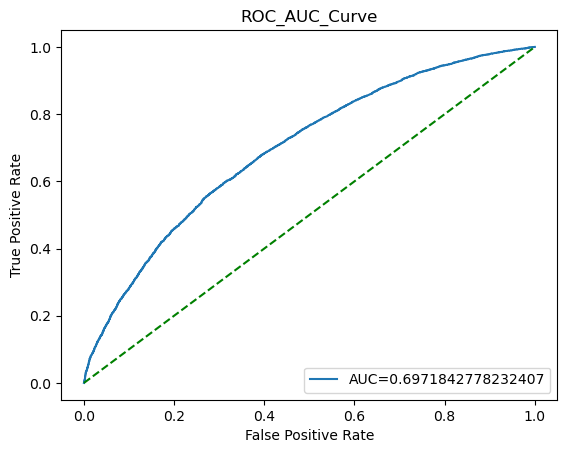

In [216]:
#Calculating the auc score and plotting it for Train Data
auc = plot_and_get_roc_auc_curve(lr_model, X_train_s1, Y_train_s1_gender)
model_evaluation_dict_gender['AUC_Training'].append(auc)

#### Evaluating the Logistic Regression classifier on Test Data Set

Evaluating Testing performance
Accuracy:0.6128077773667642
Precision:0.6485044348558805
Recall:0.6209635641512692
F1Score:0.6888731396172927
KS statistic for class Female: KstestResult(statistic=0.6568813676394405, pvalue=0.0)
KS statistic for class Male: KstestResult(statistic=0.6568813676394405, pvalue=0.0)


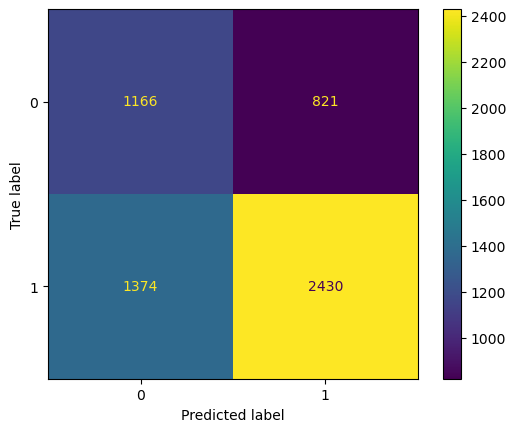

In [217]:
evaluate_model(lr_model, X_test_s1, Y_test_s1_gender, False)

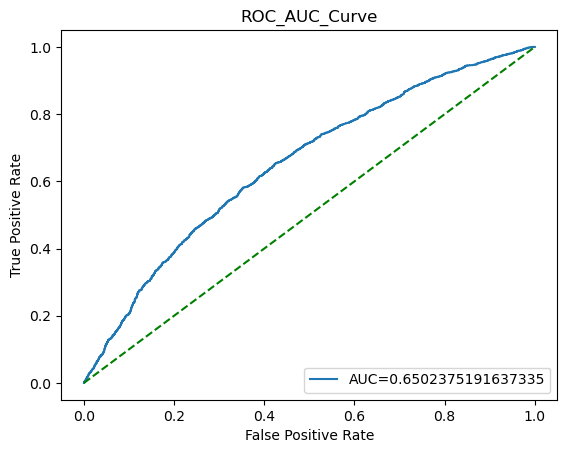

In [218]:
#Calculating the auc score and plotting it for Test Data
auc = plot_and_get_roc_auc_curve(lr_model, X_test_s1, Y_test_s1_gender)
model_evaluation_dict_gender['AUC_Testing'].append(auc)

### XGBoost Model for Predicting `Gender` for Scenario 1

In [219]:
#Training XGBoost Model on train data
'''
Model was trained and in order to avoid running it multiple times it was saved in pickle file
Uncomment below if running for first time and do not have the saved model.
'''
# xgclf = xgb.XGBClassifier(random_state=100,n_jobs=-1)
# xgclf.fit(X_train_s1, Y_train_s1_gender)

'\nModel was trained and in order to avoid running it multiple times it was saved in pickle file\nUncomment below if running for first time and do not have the saved model.\n'

In [220]:
# Saving the XGBoost Model as a pickle in a file
#Uncomment Below if Running for First Time
# path = 'E:\\Shobhit\\MSDS\\Capstone\\Y1_Capstone\\MLModels'
# filename = f'{path}\\XGBoost_Gender_Scenario1.pkl'
# pickle.dump(xgclf, open(filename, 'wb'))

In [221]:
# Reading saved XGBoost model
path = 'E:\\Shobhit\\MSDS\\Capstone\\Y1_Capstone\\MLModels'
filename = f'{path}\\XGBoost_Gender_Scenario1.pkl'
xgclf = pickle.load(open(filename, 'rb'))
print(xgclf)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, gpu_id=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=None, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=None, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              n_estimators=100, n_jobs=-1, num_parallel_tree=None,
              predictor=None, random_state=100, ...)


#### Evaluating the XGBoost classifier on Training Data Set

Evaluating Training performance
Accuracy:0.6417691577039981
Precision:0.7389166036435694
Recall:0.7341153470185728
F1Score:0.8224406727593886
KS statistic for class Female: KstestResult(statistic=0.6540739462940601, pvalue=0.0)
KS statistic for class Male: KstestResult(statistic=0.6540739462940601, pvalue=0.0)
Top 3 deciles:
   y_true  y_scores  decile  min_prob  max_prob  cum_event_pct  \
9       0  0.857206       9  0.846771  0.991019       0.000088   
8       0  0.437534       1  0.784894  0.846692       0.000088   
7       1  0.591341       2  0.736220  0.784868       0.000088   

   cum_nonevent_pct        KS  
9         -1.889129  1.889217  
8         -1.601729  1.601817  
7         -1.336769  1.336857  
Bottom 3 deciles:
   y_true  y_scores  decile  min_prob  max_prob  cum_event_pct  \
0       1  0.680025       5  0.062102  0.431967       0.000088   
1       1  0.480010       1  0.432116  0.537144       0.000088   
2       0  0.529050       1  0.537231  0.602838       0.000088  

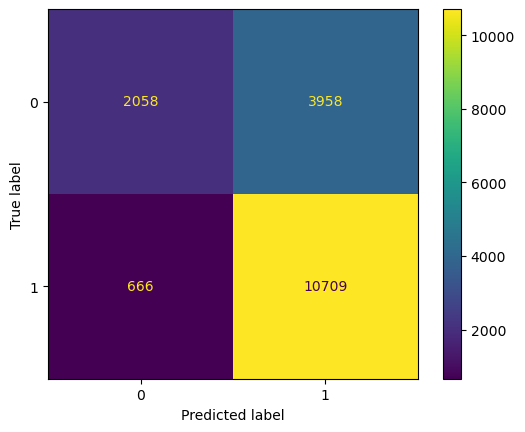

In [222]:
model_evaluation_dict_gender['Model_Name'].append('XGBoost_Basic')
evaluate_model(xgclf, X_train_s1, Y_train_s1_gender)

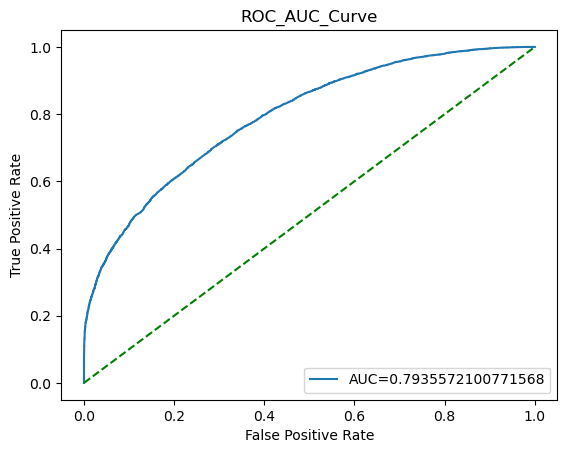

In [223]:
#Calculating the auc score and plotting it for Train Data
auc = plot_and_get_roc_auc_curve(xgclf, X_train_s1, Y_train_s1_gender)
model_evaluation_dict_gender['AUC_Training'].append(auc)

#### Evaluating the XGBoost classifier on Test Data Set

Evaluating Testing performance
Accuracy:0.5692343952833269
Precision:0.6414833210269245
Recall:0.6698324987048869
F1Score:0.779774245565538
KS statistic for class Female: KstestResult(statistic=0.6568813676394405, pvalue=0.0)
KS statistic for class Male: KstestResult(statistic=0.6568813676394405, pvalue=0.0)


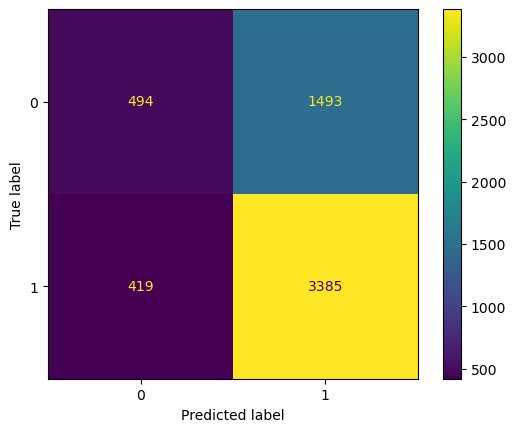

In [224]:
evaluate_model(xgclf, X_test_s1, Y_test_s1_gender, False)

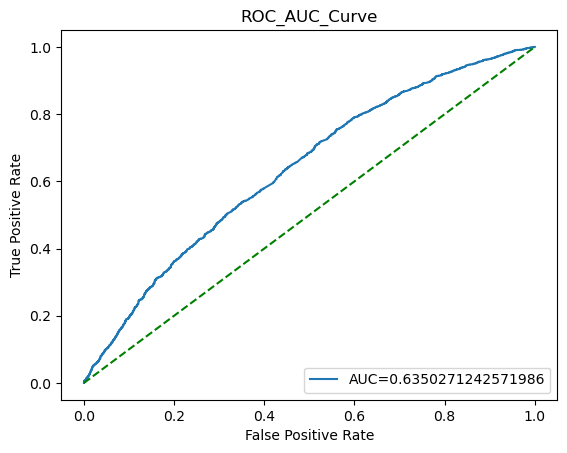

In [225]:
#Calculating the auc score and plotting it for Test Data
auc = plot_and_get_roc_auc_curve(xgclf, X_test_s1, Y_test_s1_gender)
model_evaluation_dict_gender['AUC_Testing'].append(auc)

### HyperParemter Tuning XGBoost Model for Predicting `Gender` for Scenario 1

In [226]:
#StratifiedKFold is used as we want the folds to be created to have the same proportion of class lables as in the data.
cross_validation = StratifiedKFold(n_splits=5,shuffle=True,random_state=42)

In [227]:
scorer = metrics.make_scorer(metrics.roc_auc_score,
                             greater_is_better=True,
                             needs_proba=True,
                             needs_threshold=False)

In [54]:
Creating parameter grid
param_grid = {

    'min_child_weight': [1, 5, 10],

    'gamma': [0.5, 1, 1.5, 2, 5],

    'subsample': [0.6, 0.8, 1.0],

    'colsample_by_tree': [0.6, 0.8, 1.0],

    'max_depth': [3, 4, 5],

    'n_estimators': range(60, 360, 40),

    'learning_rate': [0.1, 0.01, 0.05],

 }

In [55]:
#Training XGBoost Model
#Uncomment if running for first time
# xgb_model = xgb.XGBClassifier()
# clf_xgb_grid = RandomizedSearchCV(xgb_model,
#                               param_grid,
#                                cv=cross_validation,
#                                scoring=scorer,
#                                verbose=4,
#                                n_jobs=-1,
#                                random_state = 100,
#                                error_score="raise")
# clf_xgb_grid.fit(X_train_s1, Y_train_s1_gender)

Fitting 5 folds for each of 10 candidates, totalling 50 fits
[11:24:33] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07593ffd91cd9da33-1\xgboost\xgboost-ci-windows\src\learner.cc:767: 
Parameters: { "colsample_by_tree" } are not used.



RandomizedSearchCV(cv=StratifiedKFold(n_splits=5, random_state=42, shuffle=True),
                   error_score='raise',
                   estimator=XGBClassifier(base_score=None, booster=None,
                                           callbacks=None,
                                           colsample_bylevel=None,
                                           colsample_bynode=None,
                                           colsample_bytree=None,
                                           early_stopping_rounds=None,
                                           enable_categorical=False,
                                           eval_metric=None, feature_types=None,
                                           gamma=None, gpu_id=None,
                                           grow_...
                                           num_parallel_tree=None,
                                           predictor=None, random_state=None, ...),
                   n_jobs=-1,
                   param_distributions={'colsample_by_tree': [0.6, 0.8, 1.0],
                                        'gamma': [0.5, 1, 1.5, 2, 5],
                                        'learning_rate': [0.1, 0.01, 0.05],
                                        'max_depth': [3, 4, 5],
                                        'min_child_weight': [1, 5, 10],
                                        'n_estimators': range(60, 360, 40),
                                        'subsample': [0.6, 0.8, 1.0]},
                   random_state=100,
                   scoring=make_scorer(roc_auc_score, needs_proba=True),
                   verbose=4)

In [60]:
# print(clf_xgb_grid.best_params_)
# print(clf_xgb_grid.best_score_)
# print(clf_xgb_grid.best_estimator_)
# best_clf_xgb_grid = clf_xgb_grid.best_estimator_
# xgb_hpt = best_clf_xgb_grid

{'subsample': 0.8, 'n_estimators': 140, 'min_child_weight': 1, 'max_depth': 4, 'learning_rate': 0.1, 'gamma': 0.5, 'colsample_by_tree': 0.6}
0.6502665154499024
XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_by_tree=0.6, colsample_bylevel=None,
              colsample_bynode=None, colsample_bytree=None,
              early_stopping_rounds=None, enable_categorical=False,
              eval_metric=None, feature_types=None, gamma=0.5, gpu_id=None,
              grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=0.1, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=4, max_leaves=None,
              min_child_weight=1, missing=nan, monotone_constraints=None,
              n_estimators=140, n_jobs=None, num_parallel_tree=None,
              predictor=None, ...)


In [61]:
#Saving the model
# path = 'E:\\Shobhit\\MSDS\\Capstone\\Y1_Capstone\\MLModels'
# filename = f'{path}\\XGBoostHPT_Gender_Scenario1.pkl'
# pickle.dump(best_clf_xgb_grid, open(filename, 'wb'))

In [228]:
#Reading saved model for XGBoost with Grid Search
path = 'E:\\Shobhit\\MSDS\\Capstone\\Y1_Capstone\\MLModels'
filename = f'{path}\\XGBoostHPT_Gender_Scenario1.pkl'
xgb_hpt = pickle.load(open(filename, 'rb'))
print(xgb_hpt)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_by_tree=0.6, colsample_bylevel=None,
              colsample_bynode=None, colsample_bytree=None,
              early_stopping_rounds=None, enable_categorical=False,
              eval_metric=None, feature_types=None, gamma=0.5, gpu_id=None,
              grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=0.1, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=4, max_leaves=None,
              min_child_weight=1, missing=nan, monotone_constraints=None,
              n_estimators=140, n_jobs=None, num_parallel_tree=None,
              predictor=None, ...)


#### Evaluating the XGBoost with Hyper Parameter Tuning  on Training Data Set

Evaluating Training performance
Accuracy:0.5895868672550854
Precision:0.6902650451391235
Recall:0.6967396929446266
F1Score:0.8017144146176405
KS statistic for class Female: KstestResult(statistic=0.6540739462940601, pvalue=0.0)
KS statistic for class Male: KstestResult(statistic=0.6540739462940601, pvalue=0.0)
Top 3 deciles:
   y_true  y_scores  decile  min_prob  max_prob  cum_event_pct  \
9       0  0.825947       9  0.802802  0.934556       0.000000   
8       0  0.477323       1  0.759131  0.802779       0.000000   
7       1  0.588421       2  0.725348  0.759120       0.000176   

   cum_nonevent_pct        KS  
9         -1.889129  1.889129  
8         -1.622174  1.622174  
7         -1.383311  1.383487  
Bottom 3 deciles:
   y_true  y_scores  decile  min_prob  max_prob  cum_event_pct  \
0       1  0.676643       5  0.150292  0.474277       0.000088   
1       1  0.576736       2  0.474278  0.562961       0.000088   
2       0  0.533853       1  0.562965  0.616389       0.000000  

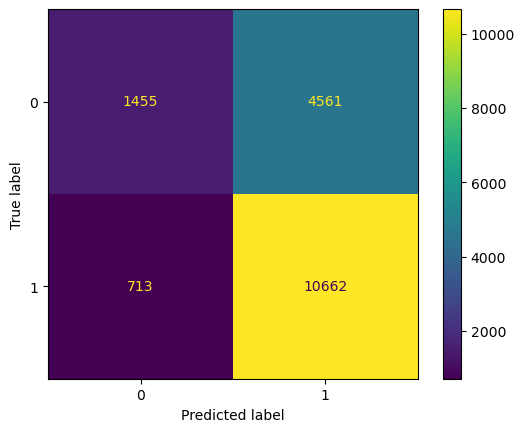

In [229]:
model_evaluation_dict_gender['Model_Name'].append('XGBoost_HPT')
evaluate_model(xgb_hpt, X_train_s1, Y_train_s1_gender)

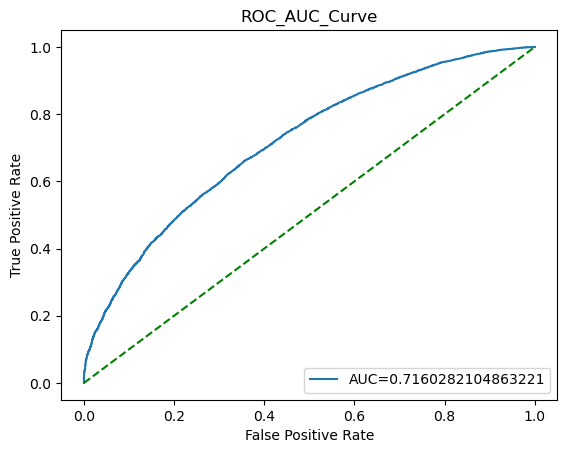

In [230]:
#Calculating the auc score and plotting it for Train Data
auc = plot_and_get_roc_auc_curve(xgb_hpt, X_train_s1, Y_train_s1_gender)
model_evaluation_dict_gender['AUC_Training'].append(auc)

#### Evaluating the XGBoost with Grid Search classifier on Test Data Set

Evaluating Testing performance
Accuracy:0.5625104848179836
Precision:0.6470013115616772
Recall:0.6736314971507512
F1Score:0.7867779783393501
KS statistic for class Female: KstestResult(statistic=0.6568813676394405, pvalue=0.0)
KS statistic for class Male: KstestResult(statistic=0.6568813676394405, pvalue=0.0)


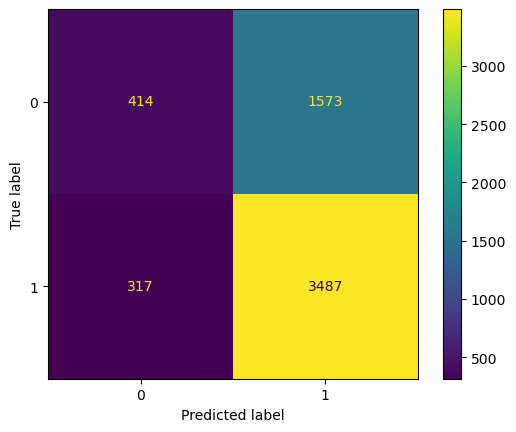

In [231]:
evaluate_model(xgb_hpt, X_test_s1, Y_test_s1_gender, False)

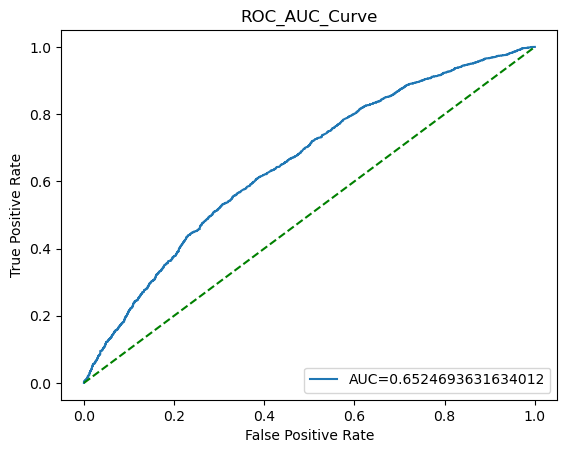

In [232]:
#Calculating the auc score and plotting it for Test Data
auc = plot_and_get_roc_auc_curve(xgb_hpt, X_test_s1, Y_test_s1_gender)
model_evaluation_dict_gender['AUC_Testing'].append(auc)

### Stacking Classifier Model  for Predicting `Gender` for Scenario 1

In [67]:
# 1st set of models
clf1 = LogisticRegression(class_weight = class_weights, random_state=100)
clf2 = RandomForestClassifier(class_weight = class_weights,random_state=100,n_jobs=-1)
xgb_m = xgb.XGBClassifier()

stacking_classifier = StackingCVClassifier(classifiers=[clf1, clf2], meta_classifier=xgb_m, use_probas=True, cv=cross_validation, random_state=100)

In [69]:
#Training Stacking Classifier Model on train data
# Performing Cross Validation on Stacking Classifier
for clf, label in zip([clf1, clf2, stacking_classifier], 
                      ['lr', 
                       'Random Forest', 
                       'StackingClassifier']):

    scores = model_selection.cross_val_score(clf, X_train_s1, Y_train_s1_gender, cv=cross_validation, scoring='accuracy')
    print("Accuracy: %0.2f (+/- %0.2f) [%s]" % (scores.mean(), scores.std(), label))

Accuracy: 0.61 (+/- 0.00) [lr]
Accuracy: 0.64 (+/- 0.01) [Random Forest]
Accuracy: 0.66 (+/- 0.00) [StackingClassifier]


In [70]:
#Fitting the Stacking Classifier on Training Data
sclf_fit = stacking_classifier.fit(X_train_s1, Y_train_s1_gender)

In [71]:
sclf_fit

StackingCVClassifier(classifiers=[LogisticRegression(class_weight={0: 1.4453956117021276,
                                                                   1: 0.7644395604395604},
                                                     random_state=100),
                                  RandomForestClassifier(class_weight={0: 1.4453956117021276,
                                                                       1: 0.7644395604395604},
                                                         n_jobs=-1,
                                                         random_state=100)],
                     cv=StratifiedKFold(n_splits=5, random_state=42, shuffle=True),
                     meta_classifier=XGBClassifier(base_score=None,
                                                   booster...
                                                   importance_type=None,
                                                   interaction_constraints=None,
                                                   learning_rate=None,
                                                   max_bin=None,
                                                   max_cat_threshold=None,
                                                   max_cat_to_onehot=None,
                                                   max_delta_step=None,
                                                   max_depth=None,
                                                   max_leaves=None,
                                                   min_child_weight=None,
                                                   missing=nan,
                                                   monotone_constraints=None,
                                                   n_estimators=100,
                                                   n_jobs=None,
                                                   num_parallel_tree=None,
                                                   predictor=None,
                                                   random_state=None, ...),
                     random_state=100, use_probas=True)

In [72]:
# Saving the Stacking Classifier Model as a pickle in a file
#Uncomment Below if Running for First Time
# path = 'E:\\Shobhit\\MSDS\\Capstone\\Y1_Capstone\\MLModels'
# filename = f'{path}\\Stacking_Classifier_Gender_Scenario1.pkl'
# pickle.dump(sclf_fit, open(filename, 'wb'))

In [233]:
# Reading saved Stacking Classifier model
path = 'E:\\Shobhit\\MSDS\\Capstone\\Y1_Capstone\\MLModels'
filename = f'{path}\\Stacking_Classifier_Gender_Scenario1.pkl'
sclf_fit = pickle.load(open(filename, 'rb'))
print(sclf_fit)

StackingCVClassifier(classifiers=[LogisticRegression(class_weight={0: 1.4453956117021276,
                                                                   1: 0.7644395604395604},
                                                     random_state=100),
                                  RandomForestClassifier(class_weight={0: 1.4453956117021276,
                                                                       1: 0.7644395604395604},
                                                         n_jobs=-1,
                                                         random_state=100)],
                     cv=StratifiedKFold(n_splits=5, random_state=42, shuffle=True),
                     meta_classifier=XGBClassifier(base_score=None,
                                                   booster...
                                                   importance_type=None,
                                                   interaction_constraints=None,
                                             

#### Evaluating the Stacking Classifier on Training Data Set

Evaluating Training performance
Accuracy:0.606501359013327
Precision:0.6820400139597836
Recall:0.6971997009947674
F1Score:0.7955745341614907
KS statistic for class Female: KstestResult(statistic=0.6540739462940601, pvalue=0.0)
KS statistic for class Male: KstestResult(statistic=0.6540739462940601, pvalue=0.0)
Top 3 deciles:
   y_true  y_scores  decile  min_prob  max_prob  cum_event_pct  \
9       0  0.804289       8  0.849801  0.985137       0.000088   
8       0  0.269003       0  0.793365  0.849754       0.000000   
7       1  0.790246       7  0.754243  0.793355       0.000088   

   cum_nonevent_pct        KS  
9         -1.889129  1.889217  
8         -1.670878  1.670878  
7         -1.435173  1.435261  
Bottom 3 deciles:
   y_true  y_scores  decile  min_prob  max_prob  cum_event_pct  \
0       1  0.653188       4  0.017306  0.417887       0.000088   
1       1  0.483685       1  0.417995  0.522117       0.000088   
2       0  0.510751       1  0.522255  0.582471       0.000088   

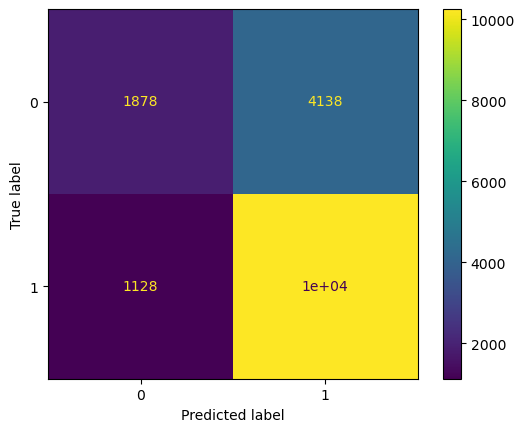

In [234]:
model_evaluation_dict_gender['Model_Name'].append('Stacking_Classifier')
evaluate_model(sclf_fit,X_train_s1, Y_train_s1_gender)

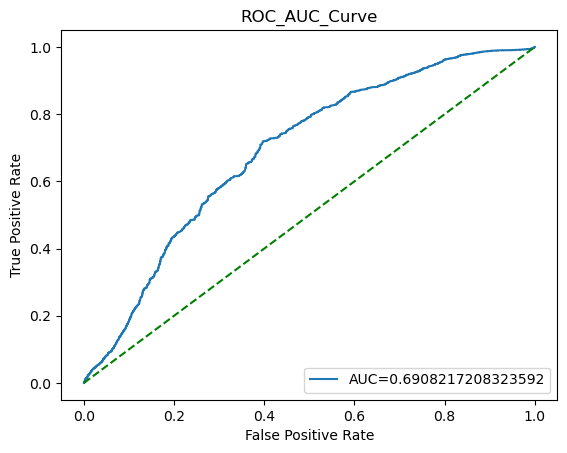

In [235]:
#Calculating the auc score and plotting it for Train Data
auc = plot_and_get_roc_auc_curve(sclf_fit, X_train_s1, Y_train_s1_gender)
model_evaluation_dict_gender['AUC_Training'].append(auc)

#### Evaluating the Stacking Classifier Model on Test Data Set

Evaluating Testing performance
Accuracy:0.55465778612506
Precision:0.6305391079114114
Recall:0.6637886375410119
F1Score:0.7790763644615907
KS statistic for class Female: KstestResult(statistic=0.6568813676394405, pvalue=0.0)
KS statistic for class Male: KstestResult(statistic=0.6568813676394405, pvalue=0.0)


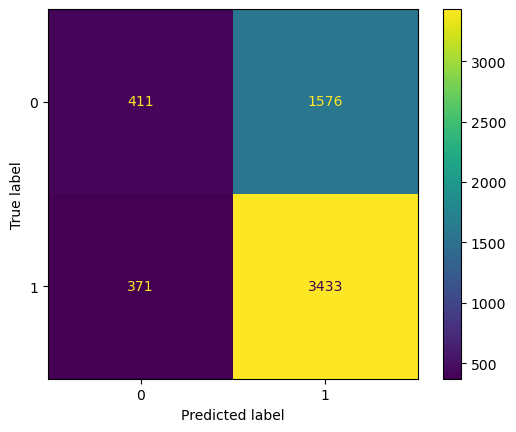

In [236]:
evaluate_model(sclf_fit, X_test_s1, Y_test_s1_gender, False)

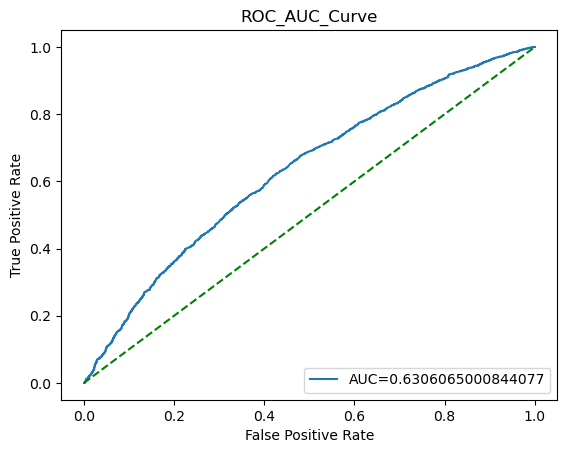

In [237]:
#Calculating the auc score and plotting it for Test Data
auc = plot_and_get_roc_auc_curve(sclf_fit, X_test_s1, Y_test_s1_gender)
model_evaluation_dict_gender['AUC_Testing'].append(auc)

### HyperParemter Tuning Stacking Classifier  for Predicting `Gender` for Scenario 1

In [176]:
# Classification Models for Stacking Classifier Model
clf1 = LogisticRegression(class_weight = class_weights)
clf2 = RandomForestClassifier(class_weight = class_weights,n_jobs=-1)

Meta Classifier for Stacking Classifer Model
xgb_m = xgb.XGBClassifier()

In [105]:
# Creating the Stacking Classifier
stacking_classifier_hpt = StackingCVClassifier(classifiers=[clf1, clf2], meta_classifier=xgb_m, use_probas=True, cv=cross_validation, random_state=100)

In [108]:
#Creating parameter grid
param_grid = {
    'randomforestclassifier__max_features':['sqrt','log2'],
    'randomforestclassifier__n_estimators': [100, 200, 300, 1000],
    'randomforestclassifier__max_depth':range(1,50,5),
    'randomforestclassifier__min_samples_leaf':range(50,350,50),
    'randomforestclassifier__min_samples_split':range(50,350,50),
    'randomforestclassifier__criterion':['gini','entropy'],
    'logisticregression__C': [0.1, 0.5,2],
    'logisticregression__max_iter': [2000],
    'meta_classifier__n_estimators': [100, 200, 300],
    'meta_classifier__learning_rate': [0.01, 0.1, 0.3],
    'meta_classifier__min_child_weight':[1, 5, 10],
    'meta_classifier__gamma': [0.5, 1, 1.5, 2, 5],
    'meta_classifier__subsample': [0.6, 0.8, 1.0],
    'meta_classifier__colsample_by_tree': [0.6, 0.8, 1.0],
    'meta_classifier__max_depth': [3, 4, 5],
}

#Hyperparmeter Tuning
stacking_classifier_cv_hpt = RandomizedSearchCV(stacking_classifier_hpt,
                              param_grid,
                               cv=cross_validation,
                               scoring='accuracy',
                               verbose=4,
                               n_jobs=-1,
                               random_state = 100,
                               error_score="raise")
stacking_classifier_cv_hpt.fit(X_train_s1, Y_train_s1_gender)

Fitting 5 folds for each of 10 candidates, totalling 50 fits
[13:02:17] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07593ffd91cd9da33-1\xgboost\xgboost-ci-windows\src\learner.cc:767: 
Parameters: { "colsample_by_tree" } are not used.



RandomizedSearchCV(cv=StratifiedKFold(n_splits=5, random_state=42, shuffle=True),
                   error_score='raise',
                   estimator=StackingCVClassifier(classifiers=[LogisticRegression(class_weight={0: 1.4453956117021276,
                                                                                                1: 0.7644395604395604}),
                                                               RandomForestClassifier(class_weight={0: 1.4453956117021276,
                                                                                                    1: 0.7644395604395604},
                                                                                      n_jobs=-1)],
                                                  cv=StratifiedKFold(n_splits=5, random_s...
                                        'randomforestclassifier__criterion': ['gini',
                                                                              'entropy'],
                                        'randomforestclassifier__max_depth': range(1, 50, 5),
                                        'randomforestclassifier__max_features': ['sqrt',
                                                                                 'log2'],
                                        'randomforestclassifier__min_samples_leaf': range(50, 350, 50),
                                        'randomforestclassifier__min_samples_split': range(50, 350, 50),
                                        'randomforestclassifier__n_estimators': [100,
                                                                                 200,
                                                                                 300,
                                                                                 1000]},
                   random_state=100, scoring='accuracy', verbose=4)

In [119]:
print(stacking_classifier_cv_hpt.best_params_)
print(stacking_classifier_cv_hpt.best_score_)
print(stacking_classifier_cv_hpt.best_estimator_)
best_stacking_classifier = stacking_classifier_cv_hpt.best_estimator_

{'randomforestclassifier__n_estimators': 1000, 'randomforestclassifier__min_samples_split': 100, 'randomforestclassifier__min_samples_leaf': 150, 'randomforestclassifier__max_features': 'sqrt', 'randomforestclassifier__max_depth': 46, 'randomforestclassifier__criterion': 'gini', 'meta_classifier__subsample': 1.0, 'meta_classifier__n_estimators': 300, 'meta_classifier__min_child_weight': 10, 'meta_classifier__max_depth': 3, 'meta_classifier__learning_rate': 0.01, 'meta_classifier__gamma': 2, 'meta_classifier__colsample_by_tree': 0.8, 'logisticregression__max_iter': 2000, 'logisticregression__C': 0.1}
0.674716697457397
StackingCVClassifier(classifiers=[LogisticRegression(C=0.1,
                                                     class_weight={0: 1.4453956117021276,
                                                                   1: 0.7644395604395604},
                                                     max_iter=2000),
                                  RandomForestClassifier(class_we

In [122]:
# Saving the Stacking Classifier Model as a pickle in a file
path = 'E:\\Shobhit\\MSDS\\Capstone\\Y1_Capstone\\MLModels'
filename = f'{path}\\Stacking_Classifier_HPT_Gender_Scenario1.pkl'
pickle.dump(best_stacking_classifier, open(filename, 'wb'))

In [238]:
# Reading saved Hyper Paramter Tuned Stacking Classifier model
path = 'E:\\Shobhit\\MSDS\\Capstone\\Y1_Capstone\\MLModels'
filename = f'{path}\\Stacking_Classifier_HPT_Gender_Scenario1.pkl'
best_stacking_classifier = pickle.load(open(filename, 'rb'))
print(best_stacking_classifier)

StackingCVClassifier(classifiers=[LogisticRegression(C=0.1,
                                                     class_weight={0: 1.4453956117021276,
                                                                   1: 0.7644395604395604},
                                                     max_iter=2000),
                                  RandomForestClassifier(class_weight={0: 1.4453956117021276,
                                                                       1: 0.7644395604395604},
                                                         max_depth=46,
                                                         min_samples_leaf=150,
                                                         min_samples_split=100,
                                                         n_estimators=1000,
                                                         n_jobs=-1)],
                     cv=StratifiedKFold(n_splits=5, random_state=42, shuffle...
                                             

#### Evaluating the Stacking Classifier on Training Data Set

Evaluating Training performance
Accuracy:0.5770116758241759
Precision:0.6640004383588525
Recall:0.6825944454027946
F1Score:0.7912412071704108
KS statistic for class Female: KstestResult(statistic=0.6540739462940601, pvalue=0.0)
KS statistic for class Male: KstestResult(statistic=0.6540739462940601, pvalue=0.0)
Top 3 deciles:
   y_true  y_scores  decile  min_prob  max_prob  cum_event_pct  \
9       0  0.796690       9  0.792763  0.856000       0.000000   
8       0  0.409216       0  0.763626  0.791897       0.000000   
7       1  0.644374       4  0.723051  0.763554       0.000088   

   cum_nonevent_pct        KS  
9         -1.889129  1.889129  
8         -1.643783  1.643783  
7         -1.422207  1.422295  
Bottom 3 deciles:
   y_true  y_scores  decile  min_prob  max_prob  cum_event_pct  \
0       1  0.741669       7  0.252524  0.463482       0.000088   
1       1  0.555990       1  0.463610  0.559542       0.000088   
2       0  0.570370       2  0.559718  0.617113       0.000000  

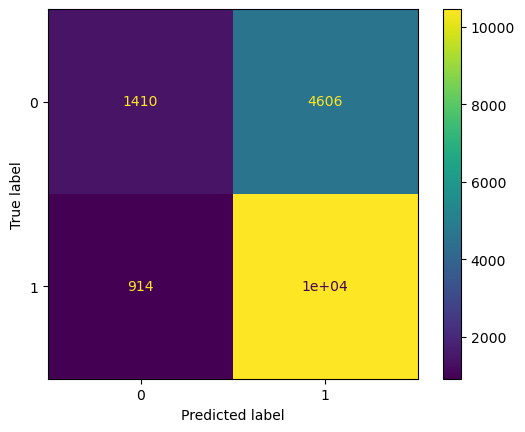

In [239]:
model_evaluation_dict_gender['Model_Name'].append('Stacking_Classifier_HPT')
evaluate_model(best_stacking_classifier, X_train_s1, Y_train_s1_gender)

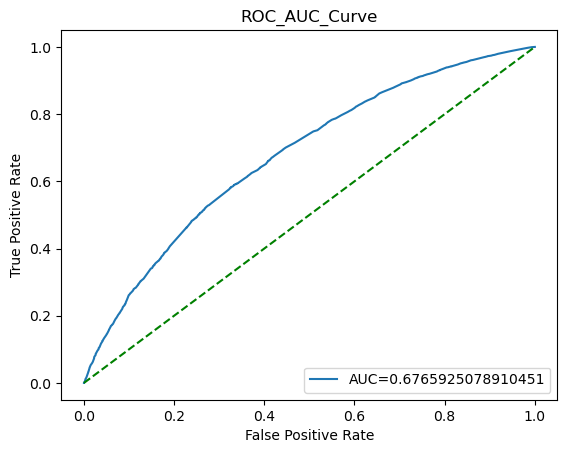

In [240]:
#Calculating the auc score and plotting it for Train Data
auc = plot_and_get_roc_auc_curve(best_stacking_classifier, X_train_s1, Y_train_s1_gender)
model_evaluation_dict_gender['AUC_Training'].append(auc)


#### Evaluating the Stacking classifier on Test Data Set

Evaluating Testing performance
Accuracy:0.570908658647137
Precision:0.6523216043281492
Recall:0.6770851321015369
F1Score:0.7872098315885298
KS statistic for class Female: KstestResult(statistic=0.6568813676394405, pvalue=0.0)
KS statistic for class Male: KstestResult(statistic=0.6568813676394405, pvalue=0.0)


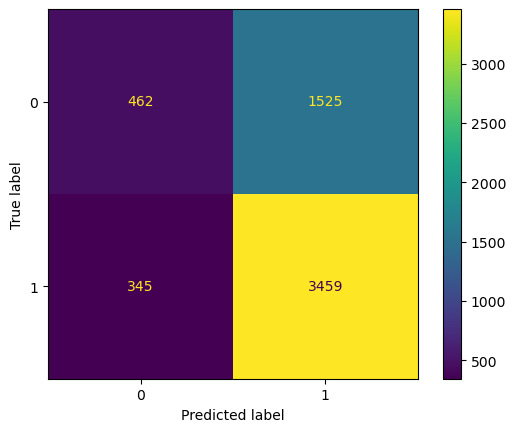

In [241]:
evaluate_model(best_stacking_classifier, X_test_s1, Y_test_s1_gender, False)

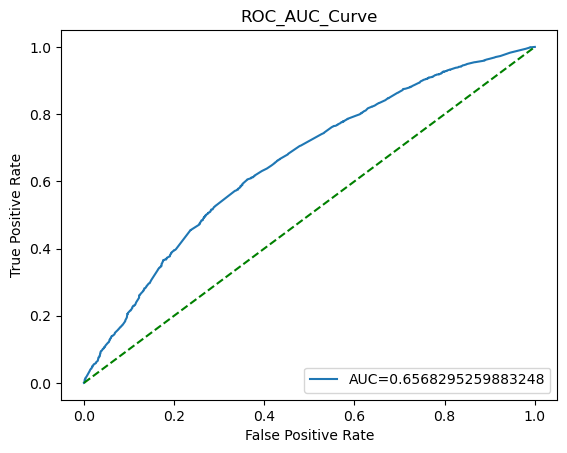

In [242]:
#Calculating the auc score and plotting it for Test Data
auc = plot_and_get_roc_auc_curve(best_stacking_classifier, X_test_s1, Y_test_s1_gender)
model_evaluation_dict_gender['AUC_Testing'].append(auc)

### Evaluation Metrics

In [248]:
model_evaluation_dict_gender

{'Model_Name': ['Logistic_Regression',
  'XGBoost_Basic',
  'XGBoost_HPT',
  'Stacking_Classifier',
  'Stacking_Classifier_HPT'],
 'Training_Accuracy': [0.6414541369534721,
  0.6417691577039981,
  0.5895868672550854,
  0.606501359013327,
  0.5770116758241759],
 'Testing_Accuracy': [0.6128077773667642,
  0.5692343952833269,
  0.5625104848179836,
  0.55465778612506,
  0.570908658647137],
 'Precision_Training': [0.6726390973328272,
  0.7389166036435694,
  0.6902650451391235,
  0.6820400139597836,
  0.6640004383588525],
 'Precision_Testing': [0.6485044348558805,
  0.6414833210269245,
  0.6470013115616772,
  0.6305391079114114,
  0.6523216043281492],
 'Recall_Training': [0.6454487953539187,
  0.7341153470185728,
  0.6967396929446266,
  0.6971997009947674,
  0.6825944454027946],
 'Recall_Testing': [0.6209635641512692,
  0.6698324987048869,
  0.6736314971507512,
  0.6637886375410119,
  0.6770851321015369],
 'F1Score_Training': [0.7071340362876413,
  0.8224406727593886,
  0.8017144146176405,
 

In [249]:
df_evaluation_gender_s1 = pd.DataFrame(model_evaluation_dict_gender)

In [250]:
df_evaluation_gender_s1

,Model_Name,Training_Accuracy,Testing_Accuracy,Precision_Training,Precision_Testing,Recall_Training,Recall_Testing,F1Score_Training,F1Score_Testing,AUC_Training,AUC_Testing,KS_Training_Male,KS_Testing_Male,KS_Training_Female,KS_Testing_Female,Top3_Probability_Bands_KSTable,Bottom3_Probability_Bands_KSTable
0,Logistic_Regression,0.641454,0.612808,0.672639,0.648504,0.645449,0.620964,0.707134,0.688873,0.697184,0.650238,"(0.6540739462940601, 0.0)","(0.6568813676394405, 0.0)","(0.6540739462940601, 0.0)","(0.6568813676394405, 0.0)","[[0.7098625106958151, 0.9864759991300046], [0....","[[0.05821964740337298, 0.31286485848167567], [..."
1,XGBoost_Basic,0.641769,0.569234,0.738917,0.641483,0.734115,0.669832,0.822441,0.779774,0.793557,0.635027,"(0.6540739462940601, 0.0)","(0.6568813676394405, 0.0)","(0.6540739462940601, 0.0)","(0.6568813676394405, 0.0)","[[0.8467710614204407, 0.9910186529159546], [0....","[[0.06210167706012726, 0.43196654319763184], [..."
2,XGBoost_HPT,0.589587,0.562510,0.690265,0.647001,0.696740,0.673631,0.801714,0.786778,0.716028,0.652469,"(0.6540739462940601, 0.0)","(0.6568813676394405, 0.0)","(0.6540739462940601, 0.0)","(0.6568813676394405, 0.0)","[[0.8028023838996887, 0.9345561861991882], [0....","[[0.15029241144657135, 0.474276602268219], [0...."
3,Stacking_Classifier,0.606501,0.554658,0.682040,0.630539,0.697200,0.663789,0.795575,0.779076,0.690822,0.630607,"(0.6540739462940601, 0.0)","(0.6568813676394405, 0.0)","(0.6540739462940601, 0.0)","(0.6568813676394405, 0.0)","[[0.8498006463050842, 0.9851365089416504], [0....","[[0.017306135967373848, 0.41788747906684875], ..."
4,Stacking_Classifier_HPT,0.577012,0.570909,0.664000,0.652322,0.682594,0.677085,0.791241,0.787210,0.676593,0.656830,"(0.6540739462940601, 0.0)","(0.6568813676394405, 0.0)","(0.6540739462940601, 0.0)","(0.6568813676394405, 0.0)","[[0.7927629947662354, 0.8560004830360413], [0....","[[0.2525236904621124, 0.463482141494751], [0.4..."


In [252]:
path = 'E:\\Shobhit\\MSDS\\Capstone\\Y1_Capstone\\MLModels'
df_evaluation_gender_s1.to_csv(f'{path}\\evaluation_metrics_gender_s1.csv',index=False)